In this file the basic ModAL PyTorch DeepActiveLearner workflow is explained 
through an example on the MNIST dataset and the MC-Dropout-Bald query strategy.

- Do previous trainings influence the performance of the next ones? or are each of them independent, like they restart from zero
- Am I doing dropout correctly? like is this what prof asked?

 If you are using a loss function like torch.nn.CrossEntropyLoss, it includes softmax internally, so you don't need to explicitly apply softmax in your model.

You can save in current working directory your trained PyTorch model using torch.save. For example:
python

- torch.save(model.state_dict(), 'your_model.pth')

This saves the state dictionary of your model to a file named 'your_model.pth'. You can later load the model using _model.load_state_dict(torch.load('your_model.pth'))_.

If you run model = YourModel() every time before the training loop, it means you are creating a new instance of the model with random weights each time. This effectively resets the model, and any training progress from previous runs will be lost.

**So after very 1st run:**
- comment out model = model() to make sure it doesnt get resetted. 
- no need to re-run wandb login
- run cells where you make changes in the parameters to tweak a bit around
- lastly run training for loop


In [19]:
from modAL.uncertainty import uncertainty_sampling
import numpy as np
import torch
# import of query strategies
from modAL.dropout import mc_dropout_bald
from modAL.models import DeepActiveLearner
from skorch import NeuralNetClassifier
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wandb

Initialize wandb

## Dataset

Load dataset

In [20]:
# Download and load the training set
train_mnist_data = MNIST(root='/Users/gabrieledele', download=True, transform=ToTensor())

# Download and load the test set
test_mnist_data = MNIST(root='/Users/gabrieledele', train=False, download=True, transform=ToTensor())

In [21]:
# Create dataloaders for training and test sets
train_dataloader = DataLoader(train_mnist_data, shuffle=True, batch_size=6000)  # Change batch_size around
test_dataloader = DataLoader(test_mnist_data, batch_size=1000)  # Change batch_size around

In [22]:
X_train, y_train = next(iter(train_dataloader))
X_test, y_test = next(iter(test_dataloader))

Make sure everything's fine with training and testing datasets

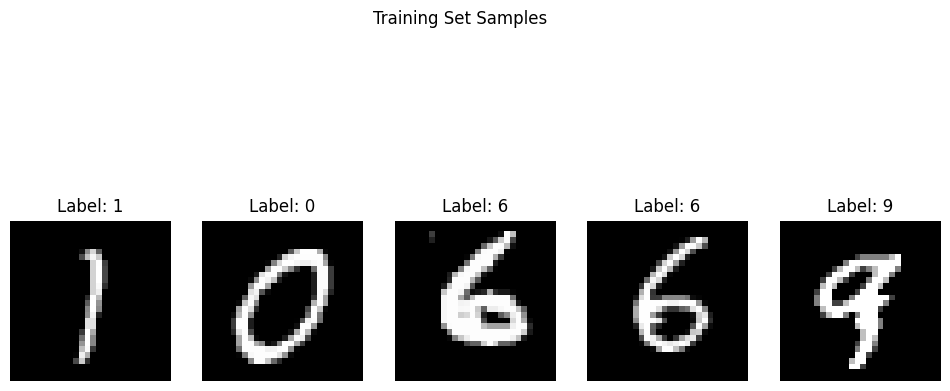

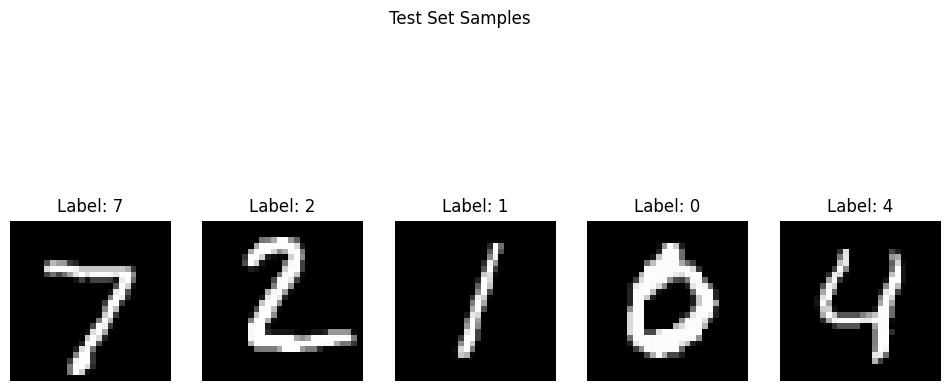

In [23]:
# Function to show images
def show_images(images, labels, title="Images"):
    plt.figure(figsize=(12, 6))
    for i in range(min(5, len(images))):  # Display up to 5 images
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Convert tensor to numpy array
X_train_numpy = X_train.numpy()
X_test_numpy = X_test.numpy()

# Show samples from the training set
show_images(X_train_numpy, y_train, title="Training Set Samples")

# Show samples from the test set
show_images(X_test_numpy, y_test, title="Test Set Samples")


In [24]:
# assemble initial data
n_initial = 2000
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

In [25]:
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

## Model

Model used

ok so ive tried with 2 and 4 conv layers too.
- 2 conv layers: started with (1,32,3)
- 4 conv layers: started with (1,16,3) and (1,8,3)...
- I also tried with 3 conv layers and now im getting a great performance so ill stick to this architecture. doesnt seem that bad. i mean it aint deep but for classifying digits that are simple and grayscale, this is perfect

- first tried with 0.5 dropout, great results (95.1)
- decided to try wih 0.6 dropout, even tho on the web they suggest max 0.5, lower results but still promising (92.3). second run of training so very little improvement. lets see with third run. no girl this shit aint going nowhere with 0.6.. might go back to 0.5

In [26]:
# Standard Pytorch Model (Visit the PyTorch documentation for more details)
class Torch_Model(nn.Module):
    def __init__(self,):
        super(Torch_Model, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.Dropout2d(0.6),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #nn.Dropout(0.5)
            nn.Dropout2d(0.6),
            nn.Conv2d(32, 64, 3),  # Input channels: 64, Output channels: 128, Kernel size: 3x3, Padding: 1
            nn.ReLU(),
            nn.MaxPool2d(2),  # Max pooling with kernel size 2x2 and default stride
            nn.Dropout2d(0.6)
        )
        
        self.fcs = nn.Sequential(
            nn.Linear(5*5*64, 128),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(128, 10),
        )
        self.input_dropout = nn.Dropout(0.8)
    def forward(self, x):
        x = self.input_dropout(x)
        out = self.convs(x)
        out = out.view(-1, 5*5*64)
        out = self.fcs(out)
        return out

Create an instance of model

In [27]:
torch_model = Torch_Model()

idk this, prolly wont be used

In [28]:
#layer_list = list(torch_model.modules())

Set to gpu or cpu if not available

In [29]:
torch.backends.mps.is_available()

True

In [30]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

mps


NNClassifier to wrap PyTorch model

In [31]:
classifier = NeuralNetClassifier(Torch_Model,
                                 max_epochs=20,
                                 criterion=torch.nn.CrossEntropyLoss,
                                 optimizer=torch.optim.SGD,
                                 lr=0.1,
                                 train_split=None,
                                 verbose=1,
                                 device=device)

## ActiveLearning Loop

In [32]:
learner = DeepActiveLearner(
    estimator=classifier,
    query_strategy=uncertainty_sampling # mc_dropout_bald,
)

# initial teaching, not necessary, without AL framework
learner.teach(X_initial, y_initial)

print("Score from sklearn: {}".format(learner.score(X_pool, y_pool)))

  epoch    train_loss     dur
-------  ------------  ------
      1        2.2916  0.5713
      2        2.1764  0.6107
      3        1.9755  0.6074
      4        1.7619  0.5246
      5        1.6130  0.5637
      6        1.4704  0.4655
      7        1.3765  0.2949
      8        1.2778  0.2803
      9        1.2654  0.2919
     10        1.1629  0.2850
     11        1.1577  0.2823
     12        1.1322  0.2814
     13        1.0873  0.2872
     14        1.0798  0.2878
     15        1.0298  0.2855
     16        1.0227  0.2821
     17        0.9924  0.2809
     18        0.9725  0.2831
     19        0.9780  0.2838
     20        0.9712  0.2809
Score from sklearn: 0.76825


In [33]:
''' from torchviz import make_dot
# Create an instance of your model
torch_model = Torch_Model()

# Dummy input (adjust the size as needed)
dummy_input = torch.randn(1, 1, 28, 28)

# Pass the dummy input through the model
output = torch_model(dummy_input)

# Visualize the architecture
dot = make_dot(output, params=dict(torch_model.named_parameters()))
dot.render("cnn_architecture", format="png", cleanup=True)
'''

' from torchviz import make_dot\n# Create an instance of your model\ntorch_model = Torch_Model()\n\n# Dummy input (adjust the size as needed)\ndummy_input = torch.randn(1, 1, 28, 28)\n\n# Pass the dummy input through the model\noutput = torch_model(dummy_input)\n\n# Visualize the architecture\ndot = make_dot(output, params=dict(torch_model.named_parameters()))\ndot.render("cnn_architecture", format="png", cleanup=True)\n'

The loop

In [34]:
# the active learning loop
n_queries = 15
X_teach = X_initial
y_teach = y_initial

In [37]:
wandb.init(
    project="24.12@12.15",
    config={
        "batch_size": 6000,
        "learning_rate": 0.1,
        "dataset": "MNIST",
    },
)

for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    """
        Query new data (num_cycles are the number of dropout forward passes that should be performed)
        --> check the documentation of mc_dropout_bald in modAL/dropout.py to see all available parameters
    """
    query_idx, metric_values = learner.query(
        X_pool, n_instances=100) #dropout_layer_indexes=[7, 11], num_cycles=10)
    # Add queried instances
    X_teach = torch.cat((X_teach, X_pool[query_idx]))
    y_teach = torch.cat((y_teach, y_pool[query_idx]))
    learner.teach(X_teach, y_teach)

    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

    # give us the model performance
    print("Model score: {}".format(learner.score(X_test, y_test)))
    wandb.log({"accuracy": learner.score(X_test, y_test)*100})
wandb.finish()

Query no. 1
    621        0.4617  1.2793
    622        0.4734  0.6890
    623        0.4768  0.9884
    624        0.4845  0.7523
    625        0.4674  0.8792
    626        0.4479  0.9481
    627        0.4585  0.8574
    628        0.4741  0.8225
    629        0.4859  0.8090
    630        0.4651  0.7080
    631        0.4610  0.8102
    632        0.4533  0.7287
    633        0.4656  0.8755
    634        0.4714  0.9564
    635        0.4779  0.8507
    636        0.4601  0.8644
    637        0.4579  0.7673
    638        0.4686  0.7768
    639        0.4639  0.6956
    640        0.4732  0.8440
Model score: 0.918
Query no. 2
    641        0.4923  0.8299
    642        0.4696  0.7679
    643        0.4723  0.8877
    644        0.4883  0.8144
    645        0.4833  0.7254
    646        0.4669  0.6995
    647        0.4633  0.7458
    648        0.4783  0.7722
    649        0.4537  0.7882
    650        0.4629  0.7338
    651        0.4399  0.7891
    652        0.4438  0.70

ValueError: need at least one array to concatenate